# Cornell Movie Review Data - Sentiment Analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
    ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from scipy.stats import spearmanr
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib  inline

# access local modules
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from emoint.featurizers.emoint_featurizer import EmoIntFeaturizer

In [2]:
def list_files(base_path, predicate):
    for folder, subs, files in os.walk(base_path):
        for filename in files:
            if predicate(os.path.join(folder, filename)):
                yield (os.path.join(folder, filename))

In [3]:
def get_xy(path):
    X = []
    y = []
    
    featurizer = EmoIntFeaturizer()
    tokenizer = TweetTokenizer()
    
    for f in list_files(path, lambda x: x.endswith('.txt')):
        data = open(f).read()
        
        tokens = tokenizer.tokenize(data)
        features = featurizer.featurize(tokens)
        X.append(features)
        
        if os.path.dirname(f).endswith('pos'):
            y.append(1)
        else:
            y.append(0)
    
    X = np.array(X)
    y = np.array(y)
    
    # shuffle the data
    np.random.seed(0)
    idx = np.random.permutation(y.size)
    X = X[idx]
    y = y[idx]
    
    print("X shape: {}".format(X.shape))
    print("y shape: {}".format(y.shape))
    
    return X, y, featurizer.features

In [4]:
X, y, features = get_xy('/Users/venkatesh/Downloads/review_polarity/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X shape: (2000, 155)
y shape: (2000,)


In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

def train(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    acc = accuracy_score(y_test_pred, y_test)
    print("Accuracy: {}".format(acc))
    return clf

def plot_fig(regr, labels, title):
    indices = np.argsort(regr.feature_importances_)[-10:]
    plt.barh(np.arange(len(indices)), regr.feature_importances_[indices])
    plt.yticks(np.arange(len(indices)) + 0.25, np.array(labels)[indices])
    plt.xlabel('Relative importance')
    plt.title(title)

Accuracy: 0.7


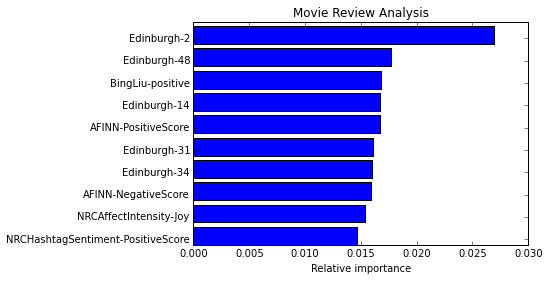

In [6]:
regr = train(X_train, y_train, X_test, y_test)
plot_fig(regr, features, "Movie Review Analysis")

In [7]:
def traincv(X, y, X_submission, y_submission, clfs, n_folds=10, shuffle=True):
    np.random.seed(0)
    if shuffle:
        idx = np.random.permutation(y.size)
        X = X[idx]
        y = y[idx]
        
    skf = list(KFold(np.size(y), n_folds))

    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))

    for j, clf in enumerate(clfs):
        dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]
            
            clf.fit(X_train, y_train)
            y_test_pred = clf.predict(X_test)
            
            dataset_blend_train[test, j] = y_test_pred
            dataset_blend_test_j[:, i] = clf.predict(X_submission)
            
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

    clf = LogisticRegression()
    clf.fit(dataset_blend_train, y)
    y_submission_pred = clf.predict(dataset_blend_test)
    
    acc = accuracy_score(y_submission_pred, y_submission)
    print("Accuracy: {}".format(acc))

In [8]:
clfs = [RandomForestClassifier(), ExtraTreesClassifier(),
        BaggingClassifier(), GradientBoostingClassifier()]
traincv(X_train, y_train, X_test, y_test, clfs)

Accuracy: 0.7425
